In [213]:
import json
from pathlib import Path
import pickle

import pandas
from matplotlib import pyplot
from pandas import DataFrame
import yaml


def log_as_dataframe(log):
    columns = ['timestamp', 'level', 'source', 'function', 'data']
    df = pandas.DataFrame(log, columns=columns)
    return df


df = log_as_dataframe(pickle.load(open('../log.pkl', 'rb')))
df = df[df['level'] == 'DATA']
df.head()

,timestamp,level,source,function,data
1,10074.0,DATA,,,"[0.000,0.000,0.000,0.084,1.578,0.099,1.448,0.0..."
2,10076.0,DATA,,,"[0.000,0.000,0.000,0.085,1.578,0.099,1.448,0.0..."
3,10078.0,DATA,,,"[0.000,0.000,0.000,0.085,1.578,0.100,1.448,0.0..."
4,10080.0,DATA,,,"[0.000,0.000,0.000,0.086,1.578,0.101,1.448,0.0..."
5,10082.0,DATA,,,"[0.000,0.000,0.000,0.087,1.578,0.102,1.448,0.0..."


In [214]:
data = []
for row in df.itertuples():
    try:
        value = yaml.load(row.data)
    except yaml.error.YAMLError:
        continue
    if len(value) != 15:
        print(value)
        continue
    data.append([row.timestamp] + value)
df = DataFrame(data)
df.columns = ['timestamp', 'side_integral', 'front_integral', 'diagonal_integral', 'front_left', 'front_right', 'side_left', 'side_right',
              'linear_ideal', 'linear_measured', 'angular_ideal', 'angular_measured',
              'voltage_left', 'voltage_right', 'pwm_left', 'pwm_right']
df['timestamp'] /= 1000
df = df.set_index('timestamp')
df = df.sort_index()
df.head()

/container/miniconda/envs/bulebule/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


[0.0, 0.0, 0.0, 0.49, 0.465, 0.11, 0.102, 0.0, 0.513, 0.445, 0.11, 0.102, 0.0, 0.0, 0.0, -0.012, 0.0, 0.0, 0, 0]
0.00,0.00,0,0]
0.110,0.102,0.000,0.000,0.000,-0.004,0.00,0.00,0,0]
[0.0, 0.0, 0.0, 0.539, 0.445, 0.11, 0.102, 0.0, 0, 0.539, 0.445, 0.11, 0.102, 0.0, 0.0, 0.0, -0.012, 0.0, 0.0, 0, 0]
[0.0, 0.0, 0.0, 0.539, 0.445, 0.11, 0.102, 0.0, '0..667', 0.445, 0.11, 0.102, 0.0, 0.0, 0.0, -0.006, 0.0, 0.0, 0, 0]
[0.0, 0.0, 0.0, 0.539, 0.465, 0.11, 0.102, 0.0, 0.0, 0.0, -0.009, 0.0, 0.0, 0.0, 0.0, -0.006, 0.0, 0.0, 0, 0]
[-0.027, 0.0, 0.0, 0.131, 0.243, '0..828', 1.206, 1.13, 0.97, 128, 109]
[-0.027, 7.442, 0.0, 0.136, 0.116, 0.384, 0.136, 0.358, 0.362, '4.7.027', 7.442, 0.0, 0.084, 0.113, 0.086, 0.248, 0.358, 0.358, 7.187, 5.451, 2.4, 0.14, 272, 16]
[0.0, 0.482, 0.0, 0.072, 0.068, 0.151, 0.051, 0.0, 0.0, -0.005, 1.02, 1.02, 115, 115]
[0.0, 3.179, 0.0, 0.072, 0.15, 0.051, 0.0, 0.0, 0.0, -0.003, 1.02, 1.02, 115, 115]


,side_integral,front_integral,diagonal_integral,front_left,front_right,side_left,side_right,linear_ideal,linear_measured,angular_ideal,angular_measured,voltage_left,voltage_right,pwm_left,pwm_right
timestamp,,,,,,,,,,,,,,,
10.074,0.0,0.0,0.0,0.084,1.578,0.099,1.448,0.0,-0.004,0.0,0.372,0.0,0.0,0,0
10.076,0.0,0.0,0.0,0.085,1.578,0.099,1.448,0.0,-0.004,0.0,0.397,0.0,0.0,0,0
10.078,0.0,0.0,0.0,0.085,1.578,0.100,1.448,0.0,-0.004,0.0,0.413,0.0,0.0,0,0
10.080,0.0,0.0,0.0,0.086,1.578,0.101,1.448,0.0,0.000,0.0,0.419,0.0,0.0,0,0
10.082,0.0,0.0,0.0,0.087,1.578,0.102,1.448,0.0,-0.004,0.0,0.428,0.0,0.0,0,0


## Linear speed feed-forward

In [215]:
df['time'] = df.index
df['acceleration'] = df['linear_ideal'].diff() / df['time'].diff()
df['angular_acceleration'] = df['angular_ideal'].diff() / df['time'].diff()
df['force'] = df['acceleration'] / 2. * 0.115

In [216]:
linear = df[(df['acceleration'] == 0) & (df['angular_ideal'] == 0) & (df['linear_ideal'] != 0)]

In [217]:
import numpy

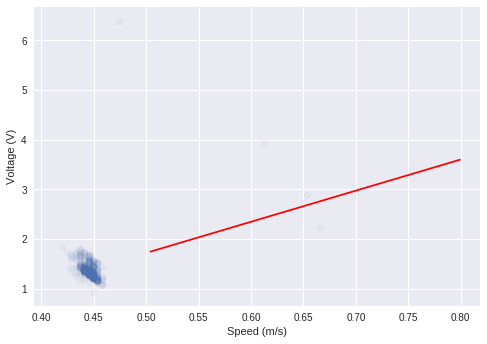

(array([-1.41616582]), array([[6.27193514]]))

In [218]:
from sklearn import linear_model

def fit_motor_linear_speed(data, y_label):
    X = numpy.expand_dims(data['linear_measured'].values, axis=1)
    y = numpy.expand_dims(data[y_label].values, axis=1)
    regr = linear_model.LinearRegression(fit_intercept=True)
    model = regr.fit(X, y)
    
    line = numpy.array([[data['linear_measured'].min() * 1.2], [data['linear_measured'].max() * 1.2]])
    pyplot.figure()
    pyplot.style.use('seaborn')
    pyplot.xlabel('Speed (m/s)')
    pyplot.ylabel('Voltage (V)')
    pyplot.scatter(x=data['linear_measured'], y=data[y_label], alpha=0.05)
    pyplot.plot(line, model.predict(line), color='red')
    pyplot.show()
    
    return model.intercept_, model.coef_

left_0, left_1 = fit_motor_linear_speed(linear, 'voltage_left')
left_0, left_1

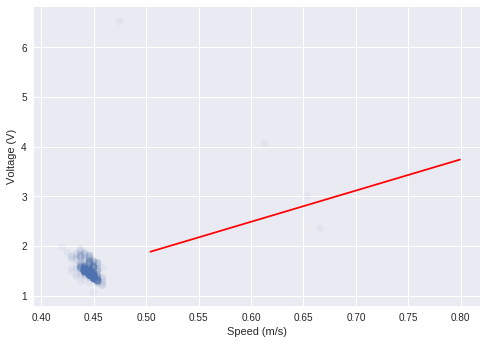

(array([-1.28394587]), array([[6.28490003]]))

In [219]:
right_0, right_1 = fit_motor_linear_speed(linear, 'voltage_right')
right_0, right_1

## Force term

In [220]:
df['voltage_force_left'] = df['voltage_left'] - left_0[0] - left_1[0][0] * df['linear_measured']
df['voltage_force_right'] = df['voltage_right'] - right_0[0] - right_1[0][0] * df['linear_measured']

In [221]:
force = df[(df['acceleration'] != 0) & (df['angular_ideal'] == 0) & (df['linear_ideal'] != 0)]

/container/miniconda/envs/bulebule/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


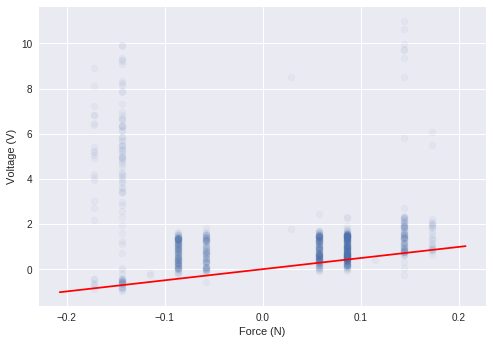

4.928264714198519

In [222]:
from sklearn.metrics import log_loss

def fit_motor_force_feedforward(data, y_label):
    data = data.dropna()
    X = numpy.expand_dims(data['force'].values, axis=1)
    y = numpy.expand_dims(data[y_label].values, axis=1)
    model = linear_model.HuberRegressor(epsilon=1.2, fit_intercept=False).fit(X, y)
    
    line = numpy.array([[data['force'].min() * 1.2], [data['force'].max() * 1.2]])
    pyplot.figure()
    pyplot.style.use('seaborn')
    pyplot.xlabel('Force (N)')
    pyplot.ylabel('Voltage (V)')
    pyplot.scatter(x=data['force'], y=data[y_label], alpha=0.05)
    pyplot.plot(line, model.predict(line), color='red')
    pyplot.show()
    
    return model.coef_[0]

fit_motor_force_feedforward(force, 'voltage_force_left')

/container/miniconda/envs/bulebule/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


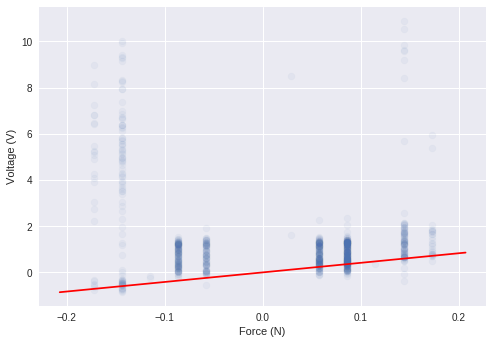

4.144241961929038

In [223]:
fit_motor_force_feedforward(force, 'voltage_force_right')

In [224]:
df['voltage_angular_left'] = df['voltage_left'] - left_0[0] - left_1[0][0] * \
    (df['linear_measured'] + df['angular_measured'] * 0.073 / 2.)
df['voltage_angular_right'] = df['voltage_right'] - right_0[0] - right_1[0][0] * \
    (df['linear_measured'] - df['angular_measured'] * 0.073 / 2.)

In [225]:
angular = df[(df['acceleration'] == 0) & (df['angular_acceleration'] == 0) & (df['angular_ideal'] != 0) & (df['linear_ideal'] != 0)]

In [226]:
def fit_motor_angular_feedforward(data, y_label):
    X = numpy.expand_dims(data['angular_measured'].values, axis=1)
    y = numpy.expand_dims(data[y_label].values, axis=1)
    regr = linear_model.LinearRegression(fit_intercept=False)
    model = regr.fit(X, y)
    
    line = numpy.array([[data['angular_measured'].min() * 1.2], [data['angular_measured'].max() * 1.2]])
    pyplot.figure()
    pyplot.style.use('seaborn')
    pyplot.xlabel('Angular velocity (rad/s)')
    pyplot.ylabel('Voltage (V)')
    pyplot.scatter(x=data['angular_measured'], y=data[y_label], alpha=0.05)
    pyplot.plot(line, model.predict(line), color='red')
    pyplot.show()
    
    return model.intercept_, model.coef_

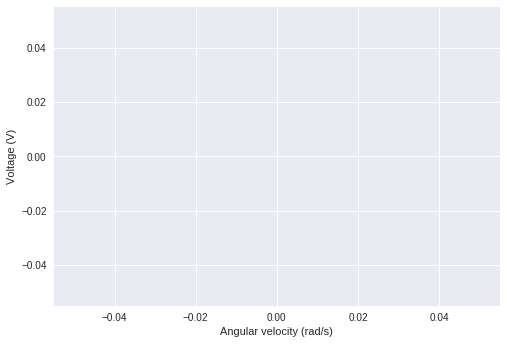

(nan, nan)

In [227]:
def reject_outliers(series, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = series.dropna().quantile([pcnt, 0.50, 1 - pcnt])
    iqr = qhigh - qlow
    return series[(series - median).abs() <= iqr]


def fit_motor_angular_feedforward(data, y_label):
    angular = data['angular_ideal']
    positive = reject_outliers(data[data['angular_ideal'] > 0][y_label]).mean()
    negative = reject_outliers(data[data['angular_ideal'] < 0][y_label]).mean()
    
    line = numpy.array([[angular.min() * 1.2], [angular.max() * 1.2]])
    pyplot.figure()
    pyplot.style.use('seaborn')
    pyplot.xlabel('Angular velocity (rad/s)')
    pyplot.ylabel('Voltage (V)')
    pyplot.scatter(x=angular, y=data[y_label], alpha=0.05)
    pyplot.plot(line, numpy.ones(line.size) * positive, color='red')
    pyplot.plot(line, numpy.ones(line.size) * negative, color='red')
    pyplot.show()
    
    return negative, positive

fit_motor_angular_feedforward(angular, 'voltage_angular_left')

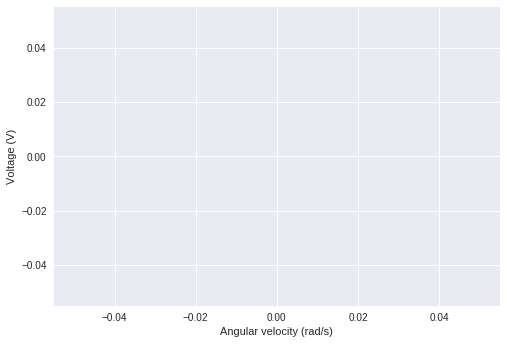

(nan, nan)

In [228]:
fit_motor_angular_feedforward(angular, 'voltage_angular_right')